# 🎬 Dividend Vision — SDXL + SVD Pipeline

## ⚠️ CRITICAL INSTRUCTIONS — READ BEFORE RUNNING

### Runtime Requirements
- **GPU**: T4 (Free Tier) or better
- **Python**: 3.10, 3.11, or 3.12 (NOT 3.13+)
- **Kernel Restarts**: **ONE mandatory restart** after Cell 1

### Execution Order (STRICT)
1. **Run Cell 1** → Install dependencies
2. **STOP** → Manually restart session (`Runtime > Restart session`)
3. **Run Cell 2** → Verify environment + mount Drive
4. **Run Cell 3** → Generate image with SDXL
5. **Run Cell 4** → Generate video with SVD

### Why Restart Is Mandatory
- Colab pre-installs NumPy 2.x (may have binary incompatibility)
- Kernel does NOT reload shared libraries after `pip install`
- Skipping restart = **Binary incompatibility crash**

### Expected Runtime
- Cell 1 (Install): ~2-3 minutes
- Cell 3 (SDXL): ~30-60 seconds
- Cell 4 (SVD): ~2-3 minutes

---

**DO NOT proceed until you understand these rules.**

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install numpy==1.26.4 diffusers==0.31.0 transformers==4.46.3 accelerate==1.2.1


Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# CELL 1 — ENVIRONMENT LOCK (INSTALL ONLY)
# ────────────────────────────────────────────────────────────────────────────────
# CRITICAL: Do NOT import ANY Python packages in this cell
# This cell ONLY performs shell commands to lock the environment
# ────────────────────────────────────────────────────────────────────────────────

import sys

# Check Python version
python_version = sys.version_info
print(f"[CHECK] Python version: {python_version.major}.{python_version.minor}.{python_version.micro}")

if python_version >= (3, 13):
    print("\n" + "="*80)
    print("❌ PYTHON 3.13+ NOT SUPPORTED")
    print("="*80)
    print("")
    print("This notebook requires Python 3.10, 3.11, or 3.12.")
    print("")
    print("SOLUTIONS:")
    print("  1. Upload and run this notebook on Google Colab (Python 3.10)")
    print("  2. Create a Python 3.12 virtual environment locally:")
    print("     > pyenv install 3.12.0")
    print("     > pyenv local 3.12.0")
    print("     > python -m venv .venv312")
    print("     > .venv312\\Scripts\\activate  (Windows)")
    print("     > source .venv312/bin/activate  (Linux/Mac)")
    print("")
    print("="*80)
    raise RuntimeError("Python 3.13+ is not compatible with required dependencies.")

print("[STEP 1/5] Purging conflicting pre-installed packages...")
%pip uninstall -y -q numpy diffusers transformers accelerate tokenizers safetensors opencv-python opencv-contrib-python opencv-python-headless jax jaxlib tensorflow keras shap pytensor torchtune peft dopamine-rl sentence-transformers numba optax timm umap-learn pymc chex librosa stumpy segregation albucore flax quantecon albumentations tensorflow-decision-forests orbax-checkpoint keras-hub 2>&1 | grep -v "WARNING"

print("[STEP 2/5] Installing PyTorch 2.5.1 + CUDA 12.1...")
%pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121 2>&1 | grep -v "ERROR: pip's dependency resolver"

print("[STEP 3/5] Installing safetensors (prevents dependency conflicts)...")
%pip install -q safetensors==0.4.5

print("[STEP 4/5] Installing remaining locked dependencies...")
%pip install -q \
  numpy==1.26.4 \
  diffusers==0.31.0 \
  transformers==4.46.3 \
  accelerate==1.2.1 \
  opencv-python==4.10.0.84 \
  pillow==11.0.0 \
  sentencepiece==0.2.0 2>&1 | grep -v "ERROR: pip's dependency resolver"

print("[STEP 5/5] Writing environment marker...")
import tempfile
from pathlib import Path
marker_path = Path(tempfile.gettempdir()) / 'dividend_vision_env_locked'
marker_path.touch()
print(f"   ✓ Marker created: {marker_path}")

print("\n" + "="*80)
print("✅ ENVIRONMENT LOCKED SUCCESSFULLY")
print("="*80)
print("")
print("🛑 STOP HERE — DO NOT CONTINUE")
print("")
print("👉 Go to: Runtime > Restart session")
print("👉 Then run Cell 2 (Verification)")
print("")
print("⚠️  Skipping restart will cause BINARY INCOMPATIBILITY errors")
print("="*80)

[CHECK] Python version: 3.12.12
[STEP 1/5] Purging conflicting pre-installed packages...
[STEP 2/5] Installing PyTorch 2.5.1 + CUDA 12.1...
pysal 25.7 requires segregation>=2.5.2, which is not installed.
tsfresh 0.21.1 requires stumpy>=1.7.2, which is not installed.
giddy 2.3.8 requires quantecon>=0.8, which is not installed.
[STEP 3/5] Installing safetensors (prevents dependency conflicts)...
[STEP 4/5] Installing remaining locked dependencies...
pysal 25.7 requires segregation>=2.5.2, which is not installed.
tsfresh 0.21.1 requires stumpy>=1.7.2, which is not installed.
giddy 2.3.8 requires quantecon>=0.8, which is not installed.
[STEP 5/5] Writing environment marker...
   ✓ Marker created: /tmp/dividend_vision_env_locked

✅ ENVIRONMENT LOCKED SUCCESSFULLY

🛑 STOP HERE — DO NOT CONTINUE

👉 Go to: Runtime > Restart session
👉 Then run Cell 2 (Verification)

⚠️  Skipping restart will cause BINARY INCOMPATIBILITY errors


In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# CELL 2 — VERIFICATION (RUN AFTER RESTART)
# ────────────────────────────────────────────────────────────────────────────────
# This cell MUST be run FIRST after kernel restart
# It verifies the environment is correctly locked before any model loading
# ────────────────────────────────────────────────────────────────────────────────

import os
import sys
import tempfile
from pathlib import Path

# CRITICAL: Import numpy FIRST to check version before anything else loads it
import numpy as np

print("[VERIFICATION] Checking NumPy version...")
assert np.__version__ == "1.26.4", f"FATAL: NumPy version mismatch. Expected 1.26.4, got {np.__version__}. Did you restart the runtime?"
print(f"✅ NumPy: {np.__version__}")

# Now safe to import PyTorch ecosystem
import torch
import diffusers
import transformers
import accelerate

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Diffusers: {diffusers.__version__}")
print(f"✅ Transformers: {transformers.__version__}")
print(f"✅ Accelerate: {accelerate.__version__}")

# Verify CUDA / Set device
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU: {gpu_name}")
    DEVICE = "cuda"
else:
    print("⚠️  GPU not available — Using CPU (slower)")
    DEVICE = "cpu"

# Verify environment marker
marker_path = Path(tempfile.gettempdir()) / 'dividend_vision_env_locked'
if not marker_path.exists():
    raise RuntimeError(
        "FATAL: Environment marker missing.\n"
        "You must run Cell 1 first to lock dependencies.\n"
        "Then restart session before running this cell."
    )
print("✅ Environment marker verified")

# Mount Google Drive (only in Colab)
try:
    print("\n[MOUNTING] Connecting to Google Drive...")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")
    OUTPUT_DIR = Path("/content/drive/MyDrive/Dividend_Vision_Output")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
except ImportError:
    print("\n⚠️  Not running on Google Colab — Using local output directory")
    OUTPUT_DIR = Path("./Dividend_Vision_Output")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"✅ Output directory: {OUTPUT_DIR}")

print("\n" + "="*80)
print("🎉 ENVIRONMENT VERIFIED — READY TO GENERATE")
print("="*80)
print(f"📌 Device: {DEVICE.upper()}")
if DEVICE == "cpu":
    print("⏱️  Warning: CPU mode is SLOW. Consider using Google Colab with GPU")
print("📌 Next: Run Cell 3 (SDXL Text-to-Image)")


[VERIFICATION] Checking NumPy version...


AssertionError: FATAL: NumPy version mismatch. Expected 1.26.4, got 2.0.2. Did you restart the runtime?

[SDXL] Loading Stable Diffusion XL pipeline...
⏳ This may take 1-2 minutes on first run (downloading ~7GB model)
⏱️  CPU mode: This will take 20-30 minutes!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ SDXL pipeline loaded successfully

[GENERATION] Creating image...
📝 Prompt: A serene Japanese garden with cherry blossoms, koi pond, and...
📊 Steps: 15 (optimized for CPU)


  0%|          | 0/15 [00:00<?, ?it/s]

✅ Image saved: /content/drive/MyDrive/Dividend_Vision_Output/sdxl_output_20260104_113340.png
📊 Size: (1024, 1024)

[PREVIEW]


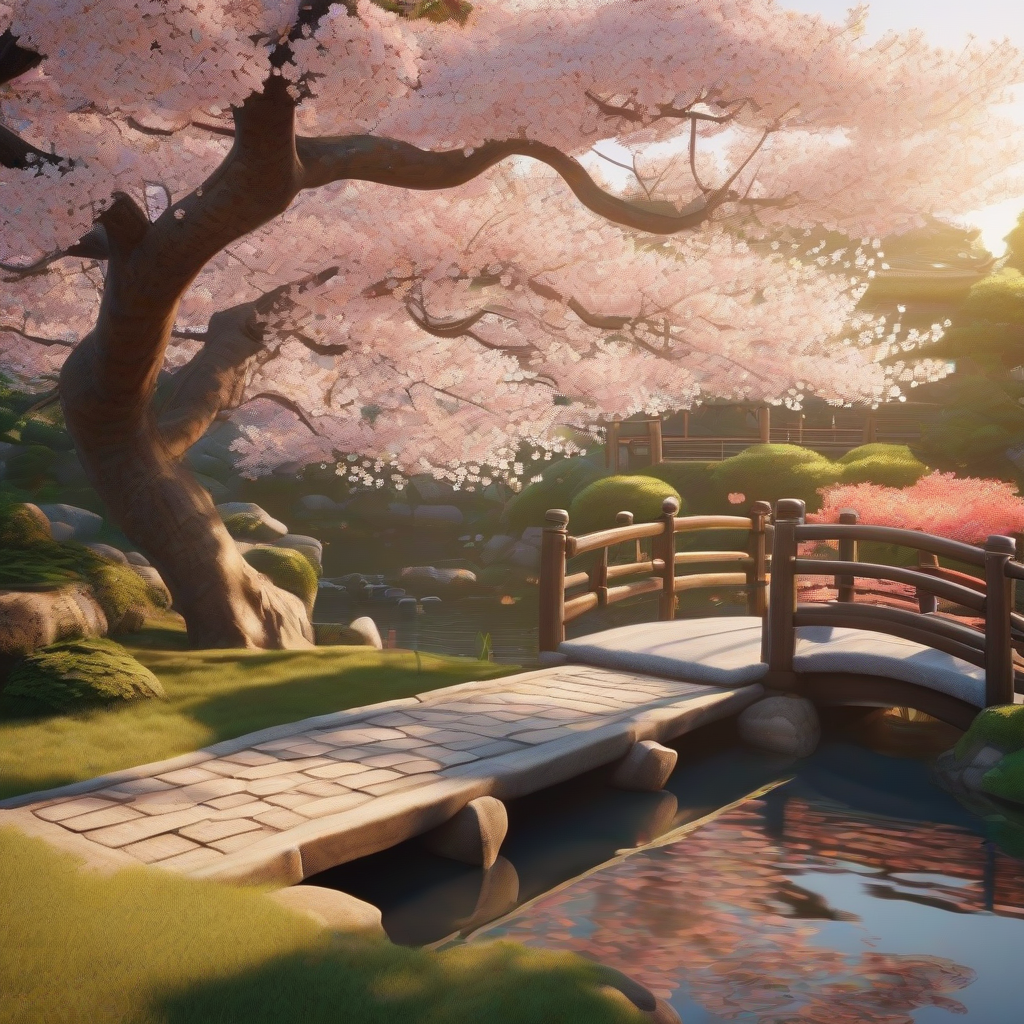


[CLEANUP] Clearing SDXL pipeline from VRAM...
✅ VRAM cleared

🎨 IMAGE GENERATION COMPLETE
📌 Next: Run Cell 4 (SVD Video Generation)


In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# CELL 3 — (แก้ไขแล้ว) REALVIS XL PHOTO-REALISTIC GENERATION
# ────────────────────────────────────────────────────────────────────────────────

import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from pathlib import Path
from datetime import datetime
from IPython.display import display

# 1. เปลี่ยนโมเดลเป็น RealVisXL V4.0 (ตัวเทพสายภาพจริง)
model_id = "SG161222/RealVisXL_V4.0"

print(f"[SDXL] Loading Photorealistic Model: {model_id}...")
sdxl_pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)

# 2. เปลี่ยน Scheduler เป็น DPM++ SDE Karras (เพื่อให้ภาพคมชัด ตัดขอบสวยแบบ HDR)
sdxl_pipe.scheduler = DPMSolverMultistepScheduler.from_config(sdxl_pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")

sdxl_pipe.to(DEVICE)
if DEVICE == "cuda":
    sdxl_pipe.enable_model_cpu_offload()

print("✅ RealVisXL pipeline loaded successfully")

# 3. ใช้ Prompt สูตรโกง (Cinematic HDR)
PROMPT = "cinematic shot of a serene Japanese garden, cherry blossoms in full bloom, koi pond, traditional wooden bridge, soft golden hour sunlight, volumetric fog, 8k, highly detailed texture, shot on ARRI Alexa, photorealistic, depth of field"
NEGATIVE_PROMPT = "cartoon, illustration, anime, drawing, painting, 3d render, plastic, blurry, distorted, text, watermark"

# RealVisXL แนะนำให้ใช้ steps น้อยลงแต่แม่นยำขึ้น
NUM_INFERENCE_STEPS = 25
GUIDANCE_SCALE = 6.0 # ค่านี้ต่ำลงนิดนึงเพื่อให้ภาพดูธรรมชาติ ไม่แข็ง
SEED = 42

print("\n[GENERATION] Creating Photorealistic Image...")
image = sdxl_pipe(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    num_inference_steps=NUM_INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    width=1280, # ปรับ Ratio เป็น 16:9 (Cinematic)
    height=720
).images[0]

# Save to Drive
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
image_path = OUTPUT_DIR / f"realvis_output_{timestamp}.png"
image.save(image_path, format="PNG")

print(f"✅ Image saved: {image_path}")
display(image)

# Store path for SVD
SDXL_IMAGE_PATH = image_path

# Cleanup
del sdxl_pipe
torch.cuda.empty_cache()

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# CELL 4 — SVD IMAGE-TO-VIDEO GENERATION
# ────────────────────────────────────────────────────────────────────────────────
# Generates video from the SDXL image using Stable Video Diffusion
# Output: ~25 frames at 6 FPS (MP4 format)
# ────────────────────────────────────────────────────────────────────────────────

import torch
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from pathlib import Path
from datetime import datetime

print("[SVD] Loading Stable Video Diffusion pipeline (XT variant)...")
print("⏳ This may take 1-2 minutes on first run (downloading ~10GB model)")
if DEVICE == "cpu":
    print("⏱️  CPU mode: This will take 30-60 minutes!")

svd_pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt",
    torch_dtype=torch.float32 if DEVICE == "cpu" else torch.float16,
    variant="fp16" if DEVICE == "cuda" else None
)
svd_pipe.to(DEVICE)
if DEVICE == "cuda":
    svd_pipe.enable_model_cpu_offload()

print("✅ SVD pipeline loaded successfully")

# Load SDXL image
print(f"\n[INPUT] Loading image: {SDXL_IMAGE_PATH}")
input_image = load_image(str(SDXL_IMAGE_PATH))

# Resize to SVD requirements (max 1024x576)
input_image = input_image.resize((1024, 576))
print(f"✅ Image resized to: {input_image.size}")

# Generation parameters
NUM_FRAMES = 25 if DEVICE == "cuda" else 10
DECODE_CHUNK_SIZE = 8 if DEVICE == "cuda" else 2
MOTION_BUCKET_ID = 127  # Motion strength (0-255, higher = more motion)
NOISE_AUG_STRENGTH = 0.02
SEED = 42

print("\n[GENERATION] Creating video...")
print(f"🎬 Frames: {NUM_FRAMES} | FPS: 6 | Duration: ~{NUM_FRAMES//6} seconds")
print(f"📊 Decode chunk: {DECODE_CHUNK_SIZE} (optimized for {DEVICE.upper()})")

generator = torch.Generator(device=DEVICE).manual_seed(SEED)

frames = svd_pipe(
    input_image,
    decode_chunk_size=DECODE_CHUNK_SIZE,
    generator=generator,
    num_frames=NUM_FRAMES,
    motion_bucket_id=MOTION_BUCKET_ID,
    noise_aug_strength=NOISE_AUG_STRENGTH
).frames[0]

print(f"✅ Generated {len(frames)} frames")

# Export to MP4
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
video_path = OUTPUT_DIR / f"svd_output_{timestamp}.mp4"

print("\n[EXPORT] Encoding MP4...")
export_to_video(frames, str(video_path), fps=6)

print(f"✅ Video saved: {video_path}")
print(f"📊 Frames: {len(frames)} | FPS: 6")

# Final cleanup
print("\n[CLEANUP] Clearing SVD pipeline from VRAM...")
del svd_pipe
del frames
torch.cuda.empty_cache()
print("✅ VRAM cleared")

print("\n" + "="*80)
print("🎉 PIPELINE COMPLETE — ALL OUTPUTS SAVED")
print("="*80)
print(f"📁 Output folder: {OUTPUT_DIR}")
print(f"🖼️  Image: {SDXL_IMAGE_PATH.name}")
print(f"🎬 Video: {video_path.name}")
print("\n💡 TIP: Download files from Google Drive or view directly in Colab")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


[SVD] Loading Stable Video Diffusion pipeline (XT variant)...
⏳ This may take 1-2 minutes on first run (downloading ~10GB model)


NameError: name 'DEVICE' is not defined